## **Ensemble Learning & Random Forests**

**Ensemble Voting Classifiers**

Consist of mutliple models, each predicting the class. Voting classifier returns the most commonly predicted class across classifiers.<br>

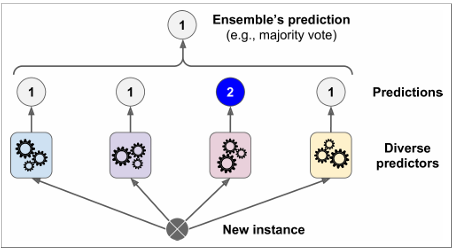

⬆️⬆️⬆️HARD VOTING CLASSIFIER⬆️⬆️⬆️

In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
X, y = make_moons(n_samples=1000, noise=0.1)

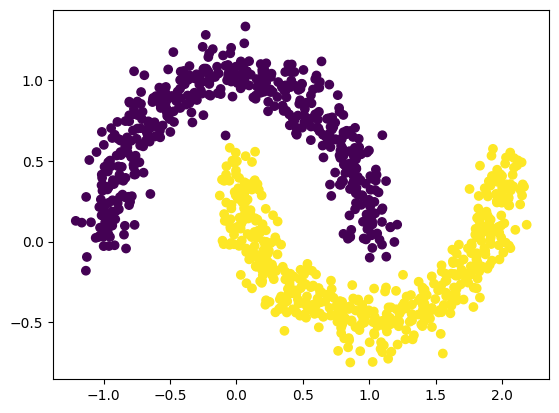

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y);

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [5]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [6]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[("rl", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard"
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rl', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_pred))

LogisticRegression 0.91
RandomForestClassifier 1.0
SVC 0.995
VotingClassifier 1.0


**Bagging And Pasting**
train the same algorithm on different subsets of the data.<br>
Bagging - sampling with replacement<br>
Pasting - sampling without replacement (like .pop)

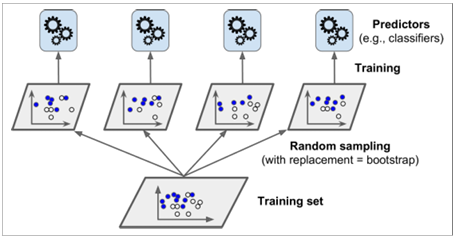

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [10]:
# Bootstrap stands for sampling with replacement.
# n_jobs=-1 uses all CPU cores

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_val)
accuracy_score(y_val, y_pred)

0.99

**Voting: Hard vs Soft**

Hard voting: ask each model for the most probable class and than pick the most frequent one among them.

Soft voting: ask each model for class probabilities, average them among models and decide from this.<br>

BaggingClassifier automatically performs soft voting if the base model supports predict_proba

**Out Of Bag Evaluation**
This random sample selection results in some of the samples being unseen by classifiers.<br>
As a result, we could use these Out of Bag samples to evaluate model on them

In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, max_samples=100, oob_score=True)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True)

In [16]:
"""
This score means that the model will perform with
~98% accuracy on unseen data (test/val sets)
"""
bag_clf.oob_score_

0.9825

In [17]:
# A bit higher than expected
pred = bag_clf.predict(X_val)
accuracy_score(y_val, pred)

0.995

In [19]:
# For each oob sample
# It shows probabilities
bag_clf.oob_decision_function_

array([[0.96153846, 0.03846154],
       [0.99546485, 0.00453515],
       [0.09706546, 0.90293454],
       ...,
       [0.10337079, 0.89662921],
       [0.        , 1.        ],
       [1.        , 0.        ]])

**Random Pathches and Random Subspaces**
We can sample features too. BaggingClassifier has corresponding `bootstrap_features=bool` and `max_features` ratio.<br>
Sampling both instances and features is called **Random Patches method** and sampling features only (keeping fixed number of instances) is called **Random Subspaces Method** (Random Forest vibes...🌲🌳🌴)

In [26]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=4, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_val)
accuracy_score(y_val, y_pred_rf)

0.93

Yeah bitch! Forests, oooooh

**Extra-Trees (extremely randomized trees)**
Works pretty much the same way random forest does, but instead of finding the best threshold for a feature it sets it randomly.

> drunk crowd guessing the weight of a cow: individually wrong, collectively accurate.

In [28]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees = ExtraTreesClassifier(n_estimators=100, max_leaf_nodes=4, n_jobs=-1)
extra_trees.fit(X_train, y_train)

y_pred_et = extra_trees.predict(X_val)
accuracy_score(y_val, y_pred_et)

0.915

**Feature Importances**
Random Forests and tree-based methods have a `feature_importances_` variable - veeery good one to give us insights about the data.<br>
It simply measures how each feature reduces impurity and scales sum of such importances for each feature to sum to 1.

In [27]:
rnd_clf.feature_importances_

array([0.36104485, 0.63895515])

In [29]:
from sklearn.datasets import load_iris

In [30]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09145136283396658
sepal width (cm) 0.023909178495930033
petal length (cm) 0.4448184609771174
petal width (cm) 0.43982099769298577


In [31]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)

In [32]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

In [33]:
X = X.to_numpy()
y = y.to_numpy()

In [46]:
rnd_clf = RandomForestClassifier(n_estimators=400, max_depth=6, n_jobs=-1)
rnd_clf.fit(X, y)

RandomForestClassifier(max_depth=6, n_estimators=400, n_jobs=-1)

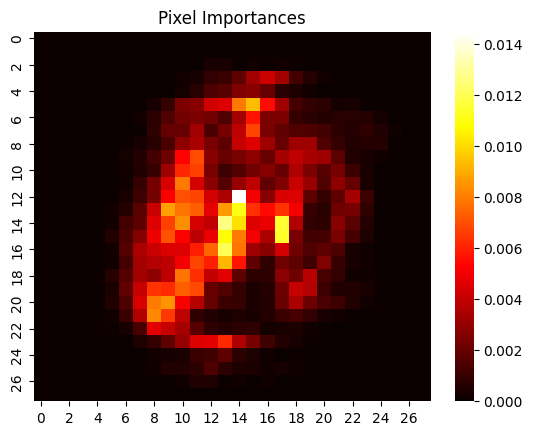

In [51]:
import seaborn as sns

plt.title("Pixel Importances")
sns.heatmap(rnd_clf.feature_importances_.reshape(28, 28), cmap="hot");

**AdaBoost**

AdaBoost trains multiple estimators sequentially.<br>
Each one focuses on the errors of a previous one setting higher weight to underfitting parts.<br>
After training model works kind of like bagging classifier.<br>
One important detail, we perform weighted voting setting higher weight to the good performing model

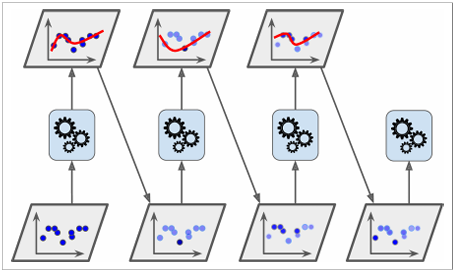

In [52]:
from sklearn.ensemble import AdaBoostClassifier

In [55]:
ada_clf=  AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, 
    learning_rate=0.5)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

**Gradient Boosting**
It starts with a base estimator, then we calculate loss (pseudo-residuals) and try to fit them with the next model.<br>
On evaluation we simply add estimators' predictions

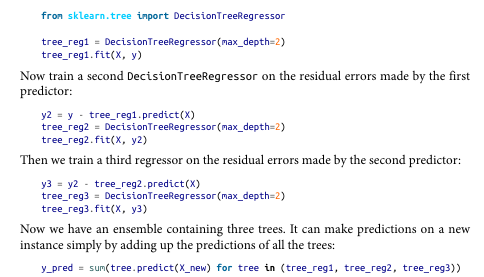

**Stacking**

This is so badass! It's simmilar to voting classifiers, but instead of using defined voting function (hard voting or soft voting) we learn it (with a **blender** model) in the 2nd layer.<br>
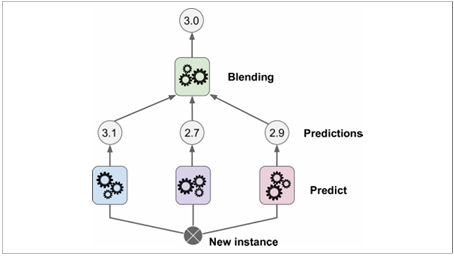

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fmedia.tenor.com%2FSN9CUCLhmZ4AAAAM%2F7.gif&f=1&nofb=1&ipt=65635e35d64915d0220c31dc3ba1a3e2ad24b731517c0a3d8cdfa8355a6f86f1" width=30% style="border-radius:20px">

It's crazy how we train it.<br>
We form 2 subsets of the data.<br>
On the one subset we train estimators.<br>
Then we make predictions on the 2nd set (holdout set) and pass these predictions (concatenated, so it's (m, k), where k-number of estimators) to the blender model, which learns to transform these predictions (maybe not quite accurate) to really accurate ones.<br>
<img src="https://i.pinimg.com/originals/e7/95/d3/e795d3bfaa35b8843bf27b83e65a111d.gif" width=30% style="border-radius:20px">

There's no sklearn implementation for it, but...

In [62]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

In [63]:
model1 = SVC()
model2 = RandomForestClassifier()
model3 = KNeighborsClassifier()

blender = DecisionTreeClassifier()

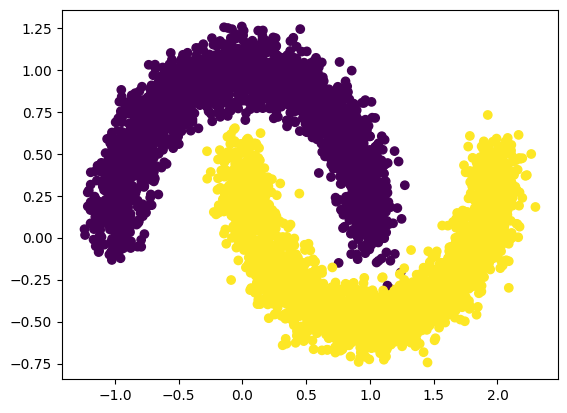

In [64]:
X, y = make_moons(n_samples=5000, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y);

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((4000, 2), (1000, 2), (4000,), (1000,))

In [66]:
X_t, X_h, y_t, y_h = train_test_split(X_train, y_train, test_size=0.2)
X_t.shape, X_h.shape, y_t.shape, y_h.shape

((3200, 2), (800, 2), (3200,), (800,))

In [67]:
model1.fit(X_t, y_t)
model2.fit(X_t, y_t)
model3.fit(X_t, y_t)

KNeighborsClassifier()

In [68]:
import numpy as np

In [72]:
predictions = np.column_stack([model.predict(X_h) for model in [model1, model2, model3]])
predictions.shape

(800, 3)

In [73]:
blender.fit(predictions, y_h)

DecisionTreeClassifier()

In [74]:
def predict(X):
    predictions = np.column_stack([model.predict(X) for model in [model1, model2, model3]])
    vote = blender.predict(predictions)
    return vote

In [75]:
preds = predict(X_val)
accuracy_score(y_val, preds)

1.0

**The dataset is too simple, the models are buffed, so this score is... honestly not what I'd like to see, but you know what? I guess I did things right**